In 2013, Diederik P. Kingma and Max Welling published a paper that laid the founda‐
tions for a type of neural network known as a variational autoencoder (VAE).

Standard :
1. Auto Encoder
2. Variational Auto Encoder

## Auto Encoder

Autoencoder consists two parts:
1. Encoder: Neural network the has the ability to compress a high dimensional input data into a lower-dimensional representation

2. Decoder: Decompress this low dimensional representation into high dimensional data

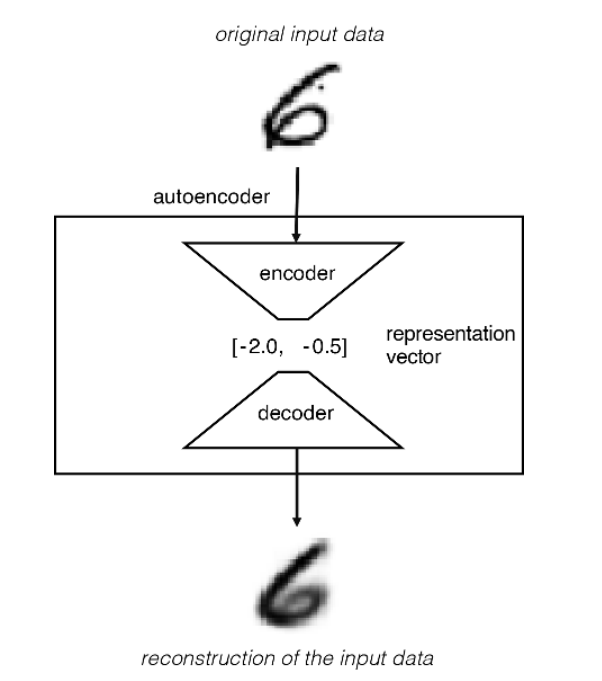

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#### CALLBACKS
class CustomCallback(Callback):

    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))

        return new_lr

    return LearningRateScheduler(schedule)

## Autoencoder Architecture

**Encoder** uses Conv2 Layers
Conv2 used *strides* to halves input data

**Decoder** uses Convolutional Transpose Layer
Conv2Transpose used *strides* to double the input data

In [ ]:
class Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False
        ):

        self.name = 'autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)


        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)

                if self.use_batch_norm:
                    x = BatchNormalization()(x)

                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate):
        self.learning_rate = learning_rate

        optimizer = Adam(lr=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        self.model.compile(optimizer=optimizer, loss = r_loss)

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)




    def load_weights(self, filepath):
        self.model.load_weights(filepath)


    def train(self, x_train, batch_size, epochs,  print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        # custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        # lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        # checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        # callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            # , callbacks = callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

In [ ]:
from keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the data

(x_train, y_train), (x_test, y_test) = load_mnist()



11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

In [ ]:
AE.encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0     

In [ ]:
AE.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                   

## Train Autoencoder

In [ ]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [ ]:
AE.compile(LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
AE.train(
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200
32/32 [==============================] - 7s 157ms/step - loss: 0.1893
Epoch 2/200
32/32 [==============================] - 3s 106ms/step - loss: 0.0862
Epoch 3/200
32/32 [==============================] - 5s 146ms/step - loss: 0.0674
Epoch 4/200
32/32 [==============================] - 4s 111ms/step - loss: 0.0639
Epoch 5/200
32/32 [==============================] - 3s 107ms/step - loss: 0.0604
Epoch 6/200
32/32 [==============================] - 3s 107ms/step - loss: 0.0565
Epoch 7/200
32/32 [==============================] - 5s 150ms/step - loss: 0.0552
Epoch 8/200
32/32 [==============================] - 3s 107ms/step - loss: 0.0545
Epoch 9/200
32/32 [==============================] - 3s 105ms/step - loss: 0.0538
Epoch 10/200
32/32 [==============================] - 5s 151ms/step - loss: 0.0533
Epoch 11/200
32/32 [==============================] - 3s 106ms/step - loss: 0.0531
Epoch 12/200
32/32 [==============================] - 3s 107ms/step - loss: 0.0526
Epoch 13/200


## Save the Model

In [ ]:
# # Save the final models
# AE.save("/content/gdrive/MyDrive/generative_model/autoencoder/autoencoder")
# AE.encoder.save("/content/gdrive/MyDrive/generative_model/autoencoder/encoder")
# AE.decoder.save("/content/gdrive/MyDrive/generative_model/autoencoder/decoder")

## Predict

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

157/157 [==============================] - 9s 52ms/step
Example real clothing items


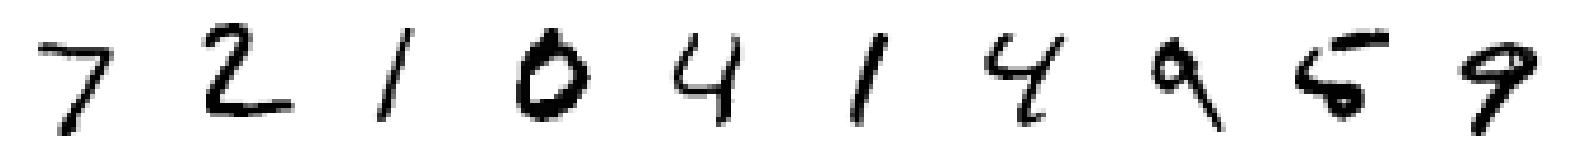

Reconstructions


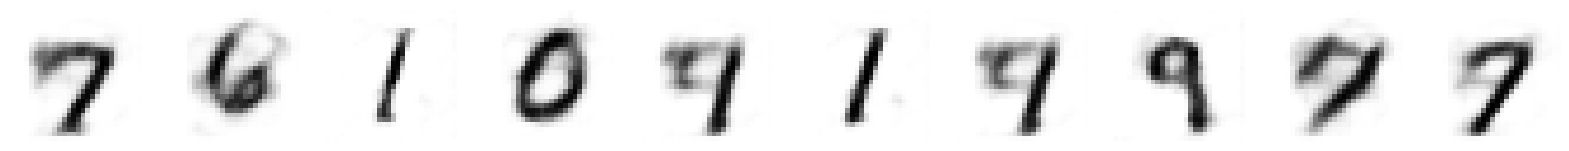

In [ ]:
predictions = AE.model.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

# Auto Encoder Analysis

## Encoder

1/1 [==============================] - 0s 238ms/step


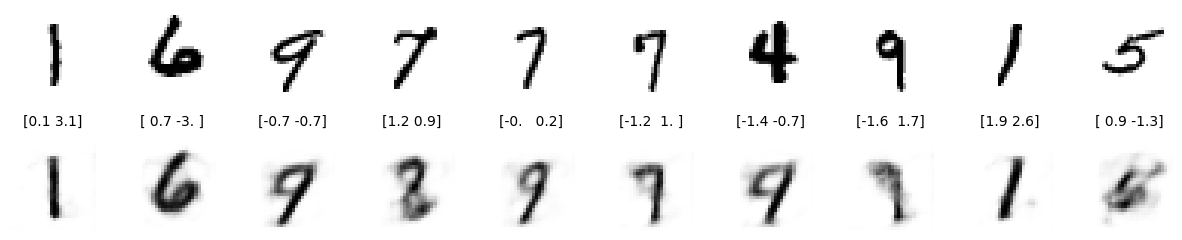

In [ ]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images) # Output: 2D Vectors

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

157/157 [==============================] - 4s 26ms/step


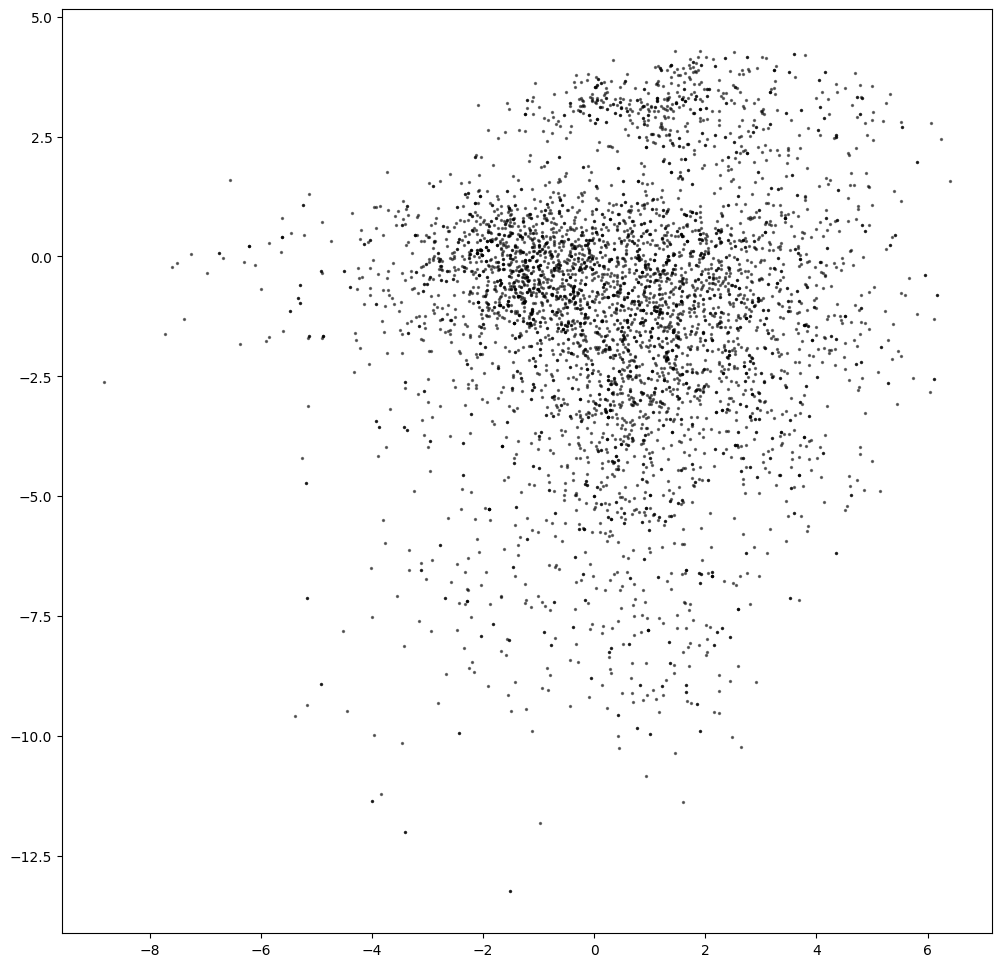

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

## New Generated

1/1 [==============================] - 0s 75ms/step


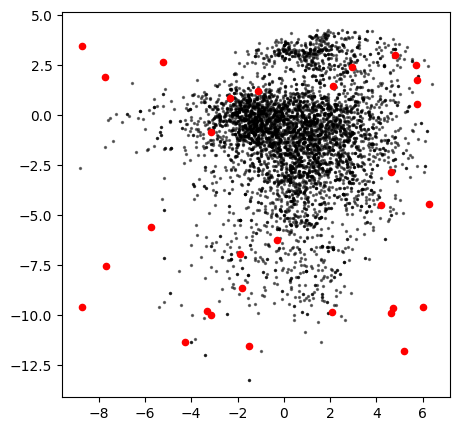

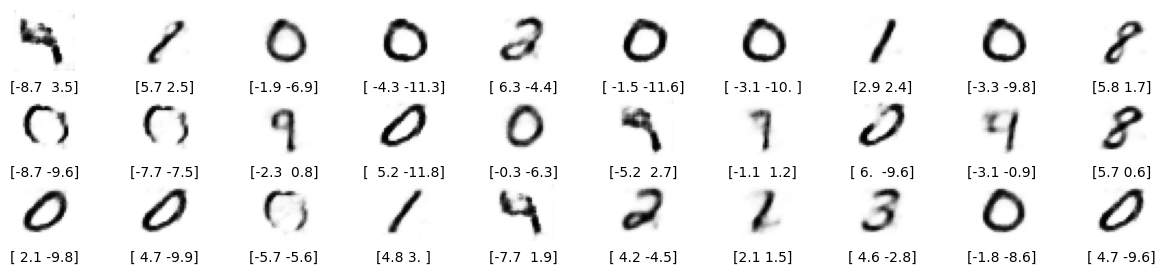

In [ ]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)

    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

157/157 [==============================] - 5s 29ms/step


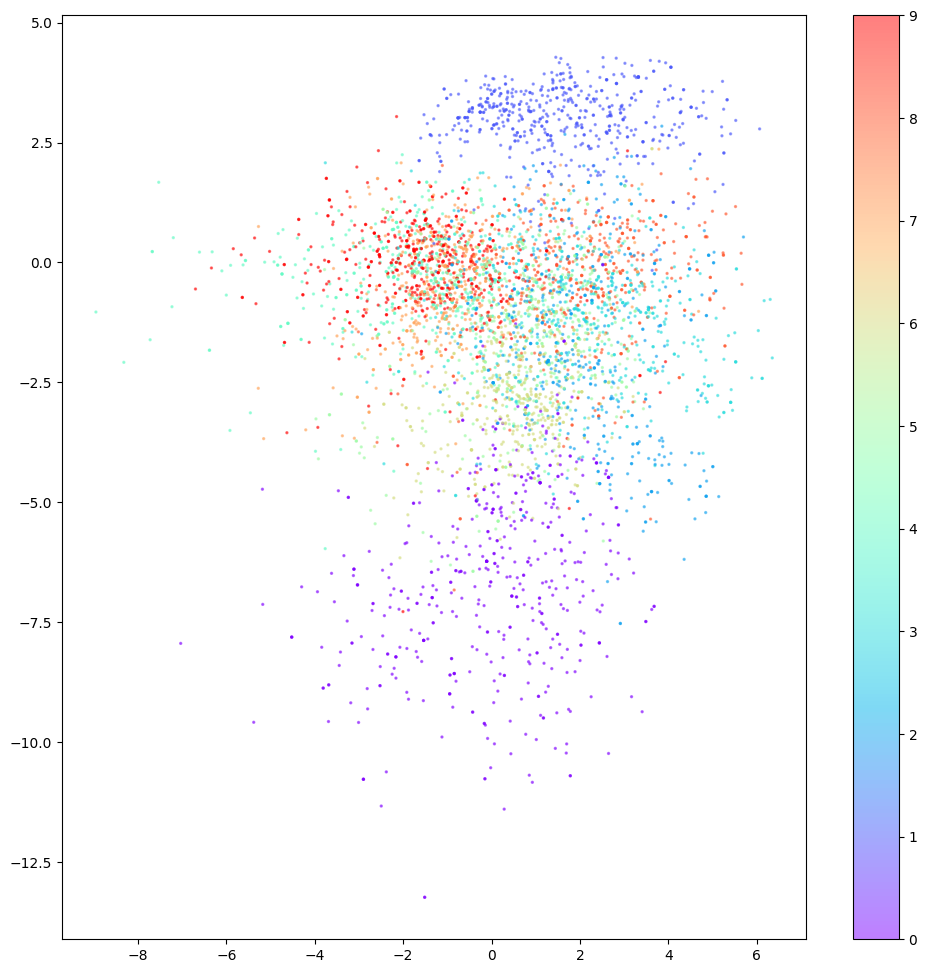

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

13/13 [==============================] - 0s 23ms/step


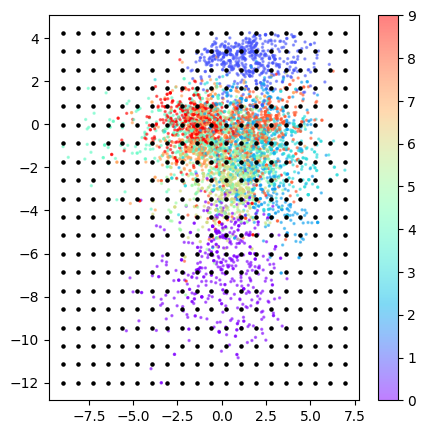

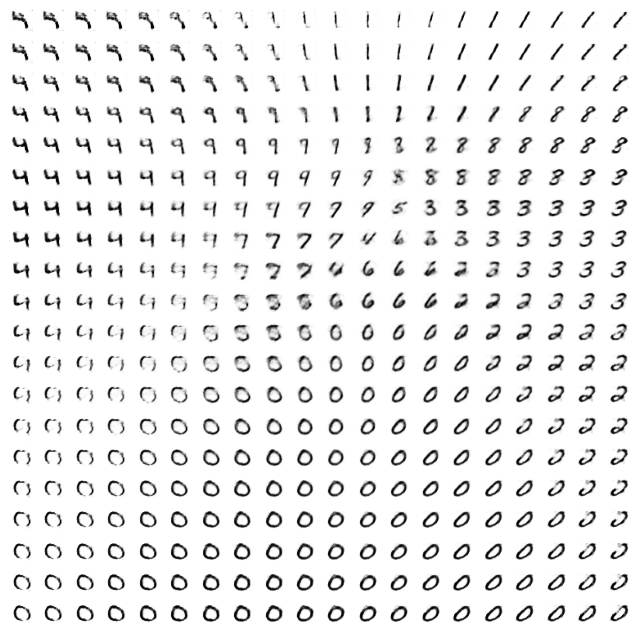

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')